In [3]:
import sys
import numpy as np
import pandas as pd
from scipy.misc import imread
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.models import Model

from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D,Lambda, Flatten, Dense
from keras.layers.merge import Concatenate
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K

from sklearn.utils import shuffle

import numpy.random as rng

import tensorflow as tf
from tensorflow.python.tools import freeze_graph
from tensorflow.python.tools import optimize_for_inference_lib

import keras2onnx
import onnx

Using TensorFlow backend.


### Please give below paths as per the paths in your system

In [4]:
train_folder = "../katzen_training/"
val_folder = '../katzen_validierung/'
save_path = '../data/'

In [5]:
def loadimgs(path,n = 0):
    '''
    path => Path of train directory or test directory
    '''
    X=[]
    y = []
    cat_dict = {}
    lang_dict = {}
    curr_y = n
    # we load every cat folder seperately so we can isolate them later
    for alphabet in os.listdir(path):
        print("loading cat folder: " + alphabet)
        lang_dict[alphabet] = [curr_y,None]
        alphabet_path = os.path.join(path,alphabet)
        # every cat has it's own column in the array, so  load seperately
        for letter in os.listdir(alphabet_path):
            cat_dict[curr_y] = (alphabet, letter)
            category_images=[]
            letter_path = os.path.join(alphabet_path, letter)
            # read all the images in the current category
            for filename in os.listdir(letter_path):
                image_path = os.path.join(letter_path, filename)
                image = imread(image_path, mode='I')
                # image = imread(image_path, mode='L')
                category_images.append(image)
                y.append(curr_y)
            try:
                X.append(np.stack(category_images))
            # edge case  - last one
            except ValueError as e:
                print(e)
                print("error - category_images:", category_images)
            curr_y += 1
            lang_dict[alphabet][1] = curr_y - 1
    y = np.vstack(y)
    X = np.stack(X)
    return X,y,lang_dict

### Loading the train images into tensors

In [6]:
X,y,c=loadimgs(train_folder)

loading cat folder: 01_katzen


/home/osboxes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


### Saving the train tensors on disk

In [7]:
with open(os.path.join(save_path,"train.pickle"), "wb") as f:
    pickle.dump((X,c),f)

### Loading the validation images into tensors

In [8]:
Xval,yval,cval=loadimgs(val_folder)

loading cat folder: 02_katzen


/home/osboxes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


### Saving the validation tensors on disk

In [9]:
with open(os.path.join(save_path,"val.pickle"), "wb") as f:
    pickle.dump((Xval,cval),f)

In [10]:
# del X, y ,c ,Xval, yval, cval

In [11]:
def get_siamese_model(input_shape):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape, name="input_1")
    right_input = Input(input_shape, name="input_2")
    
    # Convolutional Neural Network
    model = Sequential()
    #model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
    #               kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(Conv2D(12, (10,10), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D())
    #model.add(Conv2D(128, (7,7), activation='relu',
    #                 kernel_initializer=initialize_weights,
    #                 bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Conv2D(24, (7,7), activation='relu'))
    model.add(MaxPooling2D())
    #model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
    #                 bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Conv2D(24, (4,4), activation='relu'))
    model.add(MaxPooling2D())
    #model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
    #                 bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Conv2D(32, (4,4), activation='relu'))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid'))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    #prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias, name="main_output")(L1_distance)
    prediction = Dense(1,activation='sigmoid', name="main_output")(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net

In [12]:
json_path = '../01_json'

model = get_siamese_model((128, 128, 1))
model.summary()

model_json = model.to_json()
with open(os.path.join(json_path, 'model.json'), "w") as json_file:
    json_file.write(model_json)

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 4096)         8429612     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None

In [14]:
from IPython.display import Image

In [15]:
optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer)

### Loading the train tensors

In [16]:
with open(os.path.join(save_path, "train.pickle"), "rb") as f:
    (Xtrain, train_classes) = pickle.load(f)
    
print("Training alphabets: \n")
print(list(train_classes.keys()))

Training alphabets: 

['01_katzen']


In [17]:
with open(os.path.join(save_path, "val.pickle"), "rb") as f:
    (Xval, val_classes) = pickle.load(f)

print("Validation alphabets:", end="\n\n")
print(list(val_classes.keys()))

Validation alphabets:

['02_katzen']


In [18]:
def get_batch(batch_size,s="train"):
    """Create batch of n pairs, half same class, half different class"""
    if s == 'train':
        X = Xtrain
        categories = train_classes
    else:
        X = Xval
        categories = val_classes
    
    n_classes, n_examples, w, h = X.shape

    # randomly sample several classes to use in the batch
    categories = rng.choice(n_classes,size=(batch_size,),replace=False)
    
    # initialize 2 empty arrays for the input image batch
    pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]
    
    # initialize vector for the targets
    targets=np.zeros((batch_size,))
    
    # make one half of it '1's, so 2nd half of batch has same class
    targets[batch_size//2:] = 1
    for i in range(batch_size):
        category = categories[i]
        idx_1 = rng.randint(0, n_examples)
        pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, 1)
        idx_2 = rng.randint(0, n_examples)
        
        # pick images of same class for 1st half, different for 2nd
        if i >= batch_size // 2:
            category_2 = category  
        else: 
            # add a random number to the category modulo n classes to ensure 2nd image has a different category
            category_2 = (category + rng.randint(1,n_classes)) % n_classes
        
        pairs[1][i,:,:,:] = X[category_2,idx_2].reshape(w, h,1)
    
    return pairs, targets

In [19]:
def generate(batch_size, s="train"):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
        pairs, targets = get_batch(batch_size,s)
        yield (pairs, targets)

In [20]:
def make_oneshot_task(N, s="val", language=None):
    """Create pairs of test image, support set for testing N way one-shot learning. """
    if s == 'train':
        X = Xtrain
        categories = train_classes
    else:
        X = Xval
        categories = val_classes
    n_classes, n_examples, w, h = X.shape
    
    indices = rng.randint(0, n_examples,size=(N,))
    if language is not None: # if language is specified, select characters for that language
        low, high = categories[language]
        if N > high - low:
            raise ValueError("This language ({}) has less than {} letters".format(language, N))
        categories = rng.choice(range(low,high),size=(N,),replace=False)

    else: # if no language specified just pick a bunch of random letters
        categories = rng.choice(range(n_classes),size=(N,),replace=False)            
    true_category = categories[0]
    ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
    test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
    support_set = X[categories,indices,:,:]
    support_set[0,:,:] = X[true_category,ex2]
    support_set = support_set.reshape(N, w, h,1)
    targets = np.zeros((N,))
    targets[0] = 1
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image,support_set]

    return pairs, targets

In [21]:
def test_oneshot(model, N, k, s = "val", verbose = 0):
    """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
    for i in range(k):
        inputs, targets = make_oneshot_task(N,s)
        probs = model.predict(inputs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct+=1
    percent_correct = (100.0 * n_correct / k)
    if verbose:
        print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
    return percent_correct

In [22]:
# Hyper parameters
evaluate_every = 10 # interval for evaluating on one-shot tasks
batch_size = 5
n_iter = 800 # No. of training iterations
N_way = 2 # how many classes for testing one-shot tasks
n_val = 20 # how many one-shot tasks to validate on
best = -1

In [23]:
model_path = '../01_weights/'

In [ ]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter+1):
    (inputs,targets) = get_batch(batch_size)
    loss = model.train_on_batch(inputs, targets)
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
        print("Train Loss: {0}".format(loss)) 
        val_acc = test_oneshot(model, N_way, n_val, verbose=True)
        model.save_weights(os.path.join(model_path, 'weights.{}.h5'.format(i)))
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            best = val_acc

Starting training process!
-------------------------------------
Instructions for updating:
Use tf.cast instead.

 ------------- 

Time for 10 iterations: 0.31927644411722816 mins
Train Loss: 0.8561822772026062
Evaluating model on 20 random 2 way one-shot learning tasks ... 

Got an average of 55.0% 2 way one-shot learning accuracy 

Current best: 55.0, previous best: -1

 ------------- 

Time for 20 iterations: 0.46641751130421955 mins
Train Loss: 0.785117506980896
Evaluating model on 20 random 2 way one-shot learning tasks ... 

Got an average of 65.0% 2 way one-shot learning accuracy 

Current best: 65.0, previous best: 55.0

 ------------- 

Time for 30 iterations: 0.5979866822560628 mins
Train Loss: 0.5047820210456848
Evaluating model on 20 random 2 way one-shot learning tasks ... 

Got an average of 45.0% 2 way one-shot learning accuracy 


 ------------- 

Time for 40 iterations: 0.7243671735127767 mins
Train Loss: 0.5998672246932983
Evaluating model on 20 random 2 way one-shot 

## Some Visualization Functions

In [26]:
def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc, h , w, _ = X.shape
    X = X.reshape(nc, h, w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img

In [27]:
def plot_oneshot_task(pairs):
    fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2)
    ax1.matshow(pairs[0][0].reshape(128,128), cmap='CMRmap')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='CMRmap')
    plt.xticks([])
    plt.yticks([])
    plt.show()

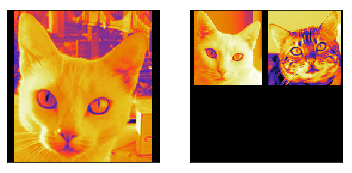

[[0.69491225]
 [0.03301172]]
Time for prediction 0.092s
[1. 0.]


(2, 128, 128, 1)

In [132]:
model.load_weights(os.path.join(model_path, "weights.300.h5"))
pairs, targets = make_oneshot_task(2,"test","02_katzen")
plot_oneshot_task(pairs)
t_start = time.time()
print(model.predict(pairs))
print("Time for prediction %.3fs" % (time.time()-t_start))
print(targets)